# Neutron - Reinforcement Learning

## Authors

* Filipe Barbosa - up201909573
* Hrvoje Maligec - up201911221
* José Pedro Baptista - up201705255

## Abstract

***TODO***

# 1. Introduction

In this project, we made a self-learning agent using reinforcement learning techniques that plays the Neutron board game. In order to implement said agent, we used Python, and OpenAi Gym, an open source library for developing and comparing reinforcement learning algorithms, as we were advised to.

### About the game

#### Name
Neutron

#### Basic knowledge
This game can be played in a 5x5 or 7x7 board.
There are two kinds of pieces, one for each player (e.g. blue and red), and the neutron.

#### Objective
The objective of this game is to bring the Neutron (N piece) to their home row/base (row where all the players pieces start) or to stalemate the opponent (preventing the opponent from playing their turn because of lack of options). 

#### Rules
The game starts with all blue pieces on Blue's home row and all red pieces on Red's home row, and the neutron in the center;
All pieces (including the neutron) move in a straight line horizontally, vertically, or diagonally, but they must move as far as they can go in the chosen direction. They can only move through or onto empty squares, and never past any piece;
Play begins with one player moving a piece from the home row. Thereafter on each turn, a player moves first the neutron and then one of his/her pieces.

#### Implementation Limitations
We don't support other boards other than the 5x5 one, due to the nature of this game and the way we are handling the different states. 

## 2. Description of the problem

### Game representation

#### Game State / Game Board
For state representation, we are using an integer matrix (array of arrays of integers), and each one of them can represent a Blue piece, Red piece, Neutron or an empty tile. 

#### Pieces
Each piece (or lack of) is represented by an integer value.

* Empty tile = 0
* Blue Piece = 1
* Red Piece = 2
* Neutron = 3

#### Moves
There are 8 possible move directions: Right, Left, Up, Down, Right-Up, Right-Down, Left-Up, Left-Down. In order to represent a move, we also need to specify the piece to apply the move to. So, our moves have the following representation:
(piece_to_move_x, piece_to_move_y, direction)


### What we needed to do
In order to make the self-learning agent with Open Ai gym, we decided to make our own, specialised environment. For that, we had to (between other things):

1. Define the observation and action spaces;
2. Allow different render modes (besides pygame), since it would slow the episodes down, and that isn't convenient while the agent is learning;
3. Incorporate CPU plays in the environment;
4. Implement a step function that returns the new state, the reward, and whether the game has ended or not, given a move.
After the environment was ready, we only had to implement the reinforcement learning algorithms to make the agent learn how to play neutron, given what the environment returned, after each action.

## 3. Approach

To implement the OpenAI Gym environment of the Neutron game, we used an [implementation we did for a previous projects](NeutronGame), that uses the Minimax algorithm for the CPU opponents. For the training, we use some of those bots as opponents for our learning bot.

Since the Neutron game board has a big number of possible states (*1.2356\*10<sup>10</sup>* for the 5x5 board), we had to something about how we stored them on the Q-table, so as not to overbear the memory. For that effect, we decided to start with an empty Q-table (for every algorithm) and only had a line for a state when that state was reached for the first time. Since the Q-table always starts with null (0) values for each action-state pair, we could just not include those cases in it. As soon as a state was reached, it is then added to the Q-table.

For the reward system, we decided to only give a positive (1) or negative (-1) reward at the end of the episode, for winning or losing the game respectively, with all the other steps returning no reward (0). However, after doing some tests, we decided that we had to do something about the invalid actions that our learning bot sometimes tried to take (invalid actions for a specific state). In the first versions of the algorithms, the invalid actions were just ignored, in the hope that the bot would just pick a random action to try next. Unfortunately, that didn't happen, which resulted in a some training sessions having a lot of episodes with unfinished games (episodes that reached the max step limit and hadn't finished) because our bot kept trying to use the same action, failing every time.

To fix that problem, we started giving some feedback to the learning bot, returning a special negative reward (-100) when the bot tries to take an invalid action for the specific state it's on. The reward value only influences the action in question and does not influence the reward values assigned to other actions. All it does is just teach the bot that that specific action should never be picked in any circumstance.

We decided to implement the **Q-learning algorithm** and the **State-action-reward-state-action (SARSA) algorithm** to use in our reinforcement learning bot.

For both algorithms we implemented to different types of **Epsilon Decay**:

1. **Exponential Decay**: `epsilon = ending_epsilon + (starting_epsilon - ending_epsilon) * e^(-decay_rate * current_episode)`
2. **Linear Decay** (the decay stops when the ending_epsilon value is reached): `epsilon = starting_epsilon + (starting_epsilon - ending_epsilon) * (-decay_rate * current_episode)`


### 3.1. Q-learning

***TODO***

### 3.2. SARSA

***TODO***

## 4. Experimental Evaluation

In [10]:
# Needed imports

import time
from NeutronRL.q_learning import QLearning
from NeutronRL.sarsa import  SARSA
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt
from NeutronRL.env_play import EnvPlay

def plot_winrate_epsilon(rewards, epsilon):
    winrate = []
    num_wins = 0

    for i in range(len(rewards)):
        if rewards[i] == 1:
            num_wins += 1

        winrate.append(num_wins / (i + 1))

    plt.plot(winrate, label="Win Rate")
    plt.plot(epsilon, label="Epsilon values")
    plt.axhline(color="black", ls="--", alpha=0.4)
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Episodes")
    plt.legend()
    plt.show()
    plt.close()

def plot_scores_decayrate(scores, decay_rate):
    plt.plot(decay_rate, scores, label="Scores")
    plt.axhline(color="black", ls="--", alpha=0.4)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Decay Rate")
    plt.xscale("log")
    plt.legend()
    plt.show()
    plt.close()

def plot_scores_learnrate(scores, decay_rate):
    plt.plot(decay_rate, scores, label="Scores")
    plt.axhline(color="black", ls="--", alpha=0.4)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Learning Rate")
    plt.legend()
    plt.show()
    plt.close()

def play_games(qtable, env, num_games, learn):
    play = EnvPlay(qtable)
    victories, defeats, unfinished = play.play_multiple(env=env, num_games=num_games, log=False, log_games=False, log_results=False, learn=learn)
    print(f"Victories: {victories}")
    print(f"Defeats: {defeats}")
    print(f"Unfinished: {unfinished}")

### 4.1. Exponential Decay vs. Linear Decay

For this test, we trained the bot with Q-Learning in 1000 episodes, using the default parameter values and playing against the Random bot.

#### Q-Learning with Exponential Decay Test

Score over time: -0.136
Time: 2.9586362838745117 seconds


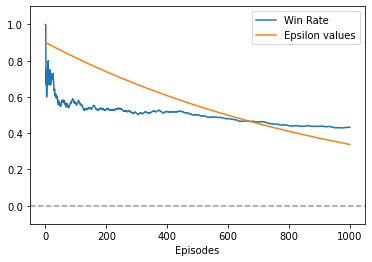

In [19]:
start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

#### Q-Learning with Linea Decay Test

Score over time: -0.186
Time: 3.188286304473877 seconds


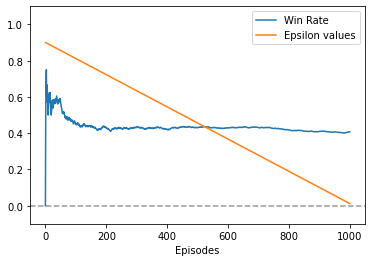

In [21]:
start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

There wasn't much diference in the results. Now we test with SARSA.

#### SARSA with Exponential Decay Test

Score over time: -0.084
Time: 2.648664951324463 seconds


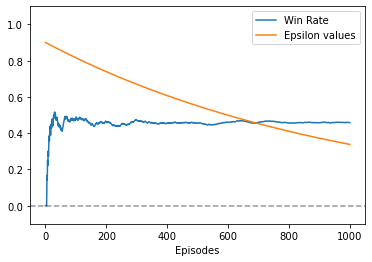

In [24]:
start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

#### SARSA with Linear Decay Test

Score over time: -0.144
Time: 3.111398935317993 seconds


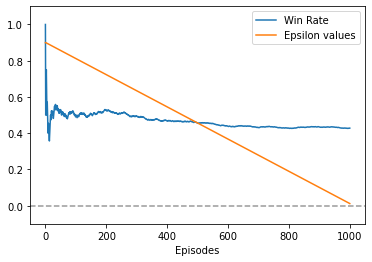

In [25]:
start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

Once again, not much difference. We believe that the decay rate is more significant than the type of decay used. We'll confirm that on the next section.

### 4.2. Decay Rate Influence

The following tests are done on both Q-Learning and SARSA algorithms and with both Linear and Exponential epsilon decay (all with 1000 episodes).

#### Q-Learning with Exponential Decay - Decay Rate Test

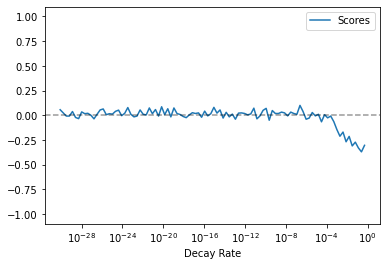

In [10]:
scores = []
decay_rates = []
decay_rate = 1

for i in range(100):
    decay_rate *= 0.5

    decay_rates.append(decay_rate)

    qlearning = QLearning(max_episodes=1000, max_steps=2000, decay_rate=decay_rate, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = qlearning.train()
    scores.append(score)

plot_scores_decayrate(scores, decay_rates)

#### Q-Learning with Linear Decay - Decay Rate Test

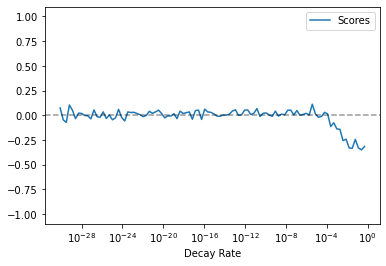

In [12]:
scores = []
decay_rates = []
decay_rate = 1

for i in range(100):
    decay_rate *= 0.5

    decay_rates.append(decay_rate)

    qlearning = QLearning(max_episodes=1000, max_steps=2000, decay_rate=decay_rate, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = qlearning.train()
    scores.append(score)

plot_scores_decayrate(scores, decay_rates)

#### SARSA with Exponential Decay - Decay Rate Test

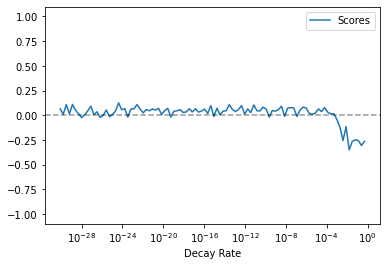

In [13]:
scores = []
decay_rates = []
decay_rate = 1

for i in range(100):
    decay_rate *= 0.5

    decay_rates.append(decay_rate)

    sarsa = SARSA(max_episodes=1000, max_steps=2000, decay_rate=decay_rate, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = sarsa.train()
    scores.append(score)

plot_scores_decayrate(scores, decay_rates)

#### SARSA with Linear Decay - Decay Rate Test

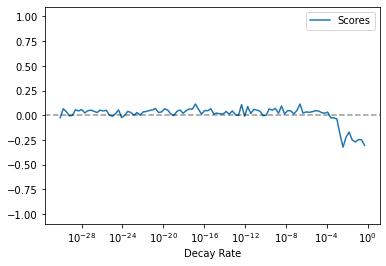

In [14]:
scores = []
decay_rates = []
decay_rate = 1

for i in range(100):
    decay_rate *= 0.5

    decay_rates.append(decay_rate)

    sarsa = SARSA(max_episodes=1000, max_steps=2000, decay_rate=decay_rate, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = sarsa.train()
    scores.append(score)

plot_scores_decayrate(scores, decay_rates)

With these results, we can conclude what we said in the previous section. For this specific case of 1000 episodes, a bigger decay rate (from about 10<sup>-4</sup> up) results in lower scores. From there on down, the scores remain about the same, with no better consistent results.

### 4.3. Learning Rate Influence

The following tests are done on both Q-Learning and SARSA algorithms and with both Linear and Exponential epsilon decay (all with 1000 episodes).

#### Q-Learning with Exponential Decay - Learning Rate Test

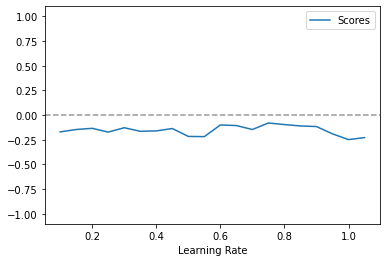

In [16]:
scores = []
learning_rates = []
learning_rate = 0.05

for i in range(20):
    learning_rate += 0.05

    learning_rates.append(learning_rate)

    qlearning = QLearning(max_episodes=1000, max_steps=2000, learning_rate=learning_rate, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = qlearning.train()
    scores.append(score)

plot_scores_learnrate(scores, learning_rates)

#### Q-Learning with Linear Decay - Learning Rate Test

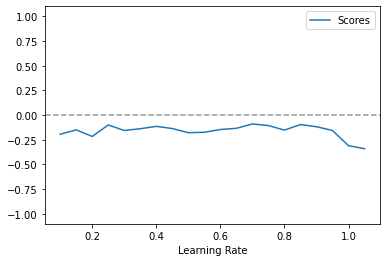

In [17]:
scores = []
learning_rates = []
learning_rate = 0.05

for i in range(20):
    learning_rate += 0.05

    learning_rates.append(learning_rate)

    qlearning = QLearning(max_episodes=1000, max_steps=2000, learning_rate=learning_rate, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = qlearning.train()
    scores.append(score)

plot_scores_learnrate(scores, learning_rates)

#### SARSA with Exponential Decay - Learning Rate Test

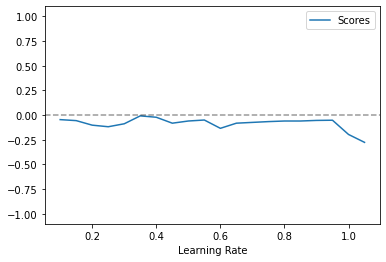

In [18]:
scores = []
learning_rates = []
learning_rate = 0.05

for i in range(20):
    learning_rate += 0.05

    learning_rates.append(learning_rate)

    sarsa = SARSA(max_episodes=1000, max_steps=2000, learning_rate=learning_rate, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = sarsa.train()
    scores.append(score)

plot_scores_learnrate(scores, learning_rates)

#### SARSA with Linear Decay - Learning Rate Test

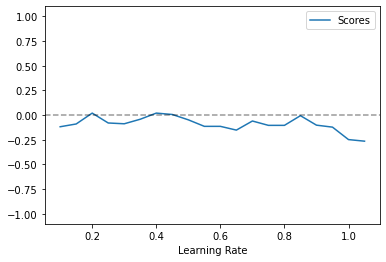

In [20]:
scores = []
learning_rates = []
learning_rate = 0.05

for i in range(20):
    learning_rate += 0.05

    learning_rates.append(learning_rate)

    sarsa = SARSA(max_episodes=1000, max_steps=2000, learning_rate=learning_rate, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False, print_final_score=False)
    score, rewards, epsilon = sarsa.train()
    scores.append(score)

plot_scores_learnrate(scores, learning_rates)

With these results, we can conclude that different learning rate doesn't influence the scores that much, except when it gets closer to 1, in which the overall scores drop a little bit more. Also, each value for the learning rate has a different effect in each different algorithm.

### 4.4. Random Bot vs. Easy Bot

We decided to try to use two different opponents for our learning bot: a **Random Bot**, that makes its plays randomly, and an **Easy Bot**, that uses Minimax to choose its best move for the current state.
Apart from analysing the win-rate, we'll also put the learning bots against the respective bots that trained them. All tests will be done with 1000 episodes and Exponential epsilon decay.

#### Q-Learning with Random Bot Test (Without Learning in Testing)

Score over time: -0.16
Time: 2.216655969619751 seconds


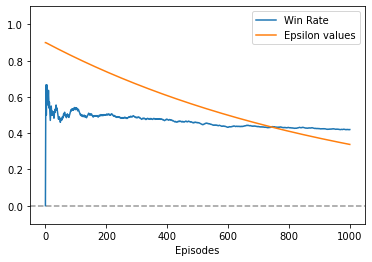

Victories: 28
Defeats: 20
Unfinished: 52


In [6]:
start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

play_games(qtable=qlearning.export_qtable(), env="Neutron-5x5-White-Random-v0", num_games=100, learn=False)

As we can see by the results, there are a lot of unfinished games. After some investigating, we discovered why. Since there are a lot of possible states on the Neutron game, 1000 episodes would never be enough to explore all actions in every state. For that reason, when playing against the random bot, the game sometimes reaches states of the game that it never saw before, and thus doesn't know how to proceed. In this situation, our bot simply picks the first action in the list (all the state-action pairs have value 0 in that specific state, since it was never reached before). If that action ends up being invalid, it will get no feedback about that, and will just keep trying to use it, halting the game until the maximum number of steps is reached.

To fix that issue, we decided to implement in testing the learning feature we referenced in the *3. Approach* section, used in training.

#### Q-Learning with Random Bot Test (With Learning in Testing)

In [7]:
play_games(qtable=qlearning.export_qtable(), env="Neutron-5x5-White-Random-v0", num_games=100, learn=True)

Victories: 43
Defeats: 57
Unfinished: 0


The results obtained are much better. Almost half of the games were won by our learning bot, and every game was finished, because our bot did not get stuck in a state it didn't know. It adapted, by checking each action until it found a valid one.

#### Q-Learning with Easy Bot Test

Score over time: -0.998
Time: 407.6814193725586 seconds


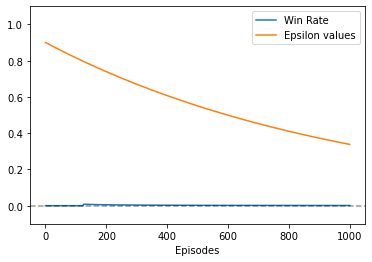

Victories: 0
Defeats: 100
Unfinished: 0


In [22]:
start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

play_games(qtable=qlearning.export_qtable(), env="Neutron-5x5-White-Easy-v0", num_games=100, learn=True)

As we can see... ***ELABORATE***

The next tests were to get a bad score with easy bot that won every game.

Score over time: -0.998
Time: 458.4851701259613 seconds


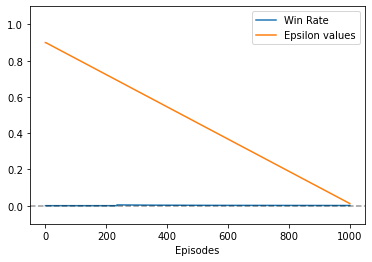

Victories: 0
Defeats: 100
Unfinished: 0


In [27]:
start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

play_games(qtable=qlearning.export_qtable(), env="Neutron-5x5-White-Easy-v0", num_games=100, learn=True)

Score over time: -0.994
Time: 390.0373532772064 seconds


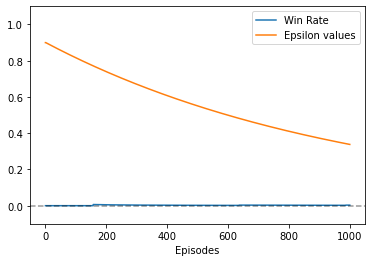

Victories: 0
Defeats: 100
Unfinished: 0


In [25]:
start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

play_games(qtable=sarsa.export_qtable(), env="Neutron-5x5-White-Easy-v0", num_games=100, learn=True)

Score over time: -0.952
Time: 395.13225388526917 seconds


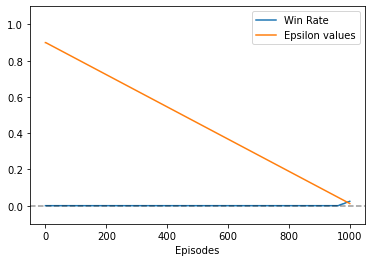

Victories: 0
Defeats: 100
Unfinished: 0


In [26]:
start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

plot_winrate_epsilon(rewards, epsilon)

play_games(qtable=sarsa.export_qtable(), env="Neutron-5x5-White-Easy-v0", num_games=100, learn=True)

### 4.5. Q-Learning vs. SARSA

### 4.6. Long Test

Score over time: -1.0
Time: 238.50839853286743 seconds


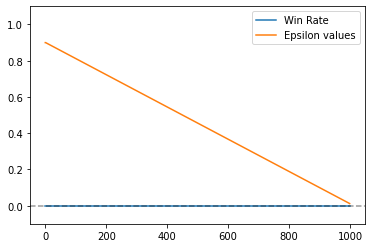

In [6]:
import time
from NeutronRL.q_learning import QLearning
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilon, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

### 4.2. SARSA

Score over time: -0.996
Time: 182.51864099502563 seconds


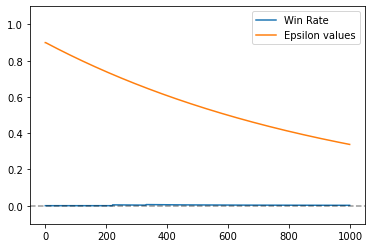

In [9]:
import time
from NeutronRL.sarsa import SARSA
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilon, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

Score over time: -0.992
Time: 184.7209393978119 seconds


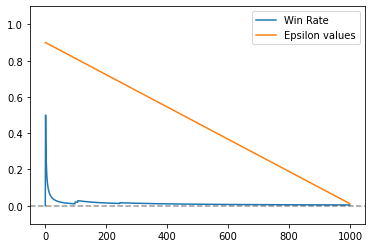

In [10]:
import time
from NeutronRL.sarsa import SARSA
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

sarsa = SARSA(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = sarsa.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilon, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

## 5. Conclusions

***TODO***

## References

***TODO***